In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.integrate import quad

# Declaring TFIModel 

Note this is taken from the tenpy documentation: https://tenpy.readthedocs.io/en/latest/toycode_stubs/b_model.html

In [2]:
class TFIModel:
    r"""Simple class generating the Hamiltonian of the transverse-field Ising model.

    The Hamiltonian reads
    .. math ::
        H = - J \sum_{i} \sigma^z_i \sigma^z_{i+1} - g \sum_{i} \sigma^x_i

    Parameters
    ----------
    L : int
        Number of sites.
    J, g : float
        Coupling parameters of the above defined Hamiltonian.
    bc : 'infinite', 'finite'
        Boundary conditions.

    Attributes
    ----------
    L : int
        Number of sites.
    bc : 'infinite', 'finite'
        Boundary conditions.
    sigmax, sigmay, sigmaz, id :
        Local operators, namely the Pauli matrices and identity.
    H_bonds : list of np.Array[ndim=4]
        The Hamiltonian written in terms of local 2-site operators, ``H = sum_i H_bonds[i]``.
        Each ``H_bonds[i]`` has (physical) legs (i out, (i+1) out, i in, (i+1) in),
        in short ``i j i* j*``.
    H_mpo : lit of np.Array[ndim=4]
        The Hamiltonian written as an MPO.
        Each ``H_mpo[i]`` has legs (virtual left, virtual right, physical out, physical in),
        in short ``wL wR i i*``.
    """
    def __init__(self, L, J, g, bc='finite'):
        assert bc in ['finite', 'infinite']
        self.L, self.d, self.bc = L, 2, bc
        self.J, self.g = J, g
        self.sigmax = np.array([[0., 1.], [1., 0.]])
        self.sigmay = np.array([[0., -1j], [1j, 0.]])
        self.sigmaz = np.array([[1., 0.], [0., -1.]])
        self.id = np.eye(2)
        self.init_H_bonds()
        self.init_H_mpo()

    def init_H_bonds(self):
        """Initialize `H_bonds` hamiltonian.

        Called by __init__().
        """
        X, Z, Id = self.sigmax, self.sigmaz, self.id
        d = self.d
        nbonds = self.L - 1 if self.bc == 'finite' else self.L
        H_list = []
        for i in range(nbonds):
            gL = gR = 0.5 * self.g
            if self.bc == 'finite':
                if i == 0:
                    gL = self.g
                if i + 1 == self.L - 1:
                    gR = self.g
            H_bond = -self.J * np.kron(Z, Z) - gL * np.kron(X, Id) - gR * np.kron(Id, X)
            # note: kron is short-hand for outer product + grouping bra and ket legs.
            # H_bond has legs ``i, j, i*, j*``
            H_list.append(np.reshape(H_bond, [d, d, d, d]))
        self.H_bonds = H_list

    # (note: not required for TEBD)
    def init_H_mpo(self):
        """Initialize `H_mpo` Hamiltonian.

        Called by __init__().
        """
        w_list = []
        for i in range(self.L):
            w = np.zeros((3, 3, self.d, self.d), dtype=float)
            w[0, 0] = w[2, 2] = self.id
            w[0, 1] = self.sigmaz
            w[0, 2] = -self.g * self.sigmax
            w[1, 2] = -self.J * self.sigmaz
            w_list.append(w)
        self.H_mpo = w_list

In [3]:
def infinite_gs_energy(J, g):
    """For comparison: Calculate groundstate energy density from analytic formula.

    The analytic formula stems from mapping the model to free fermions, see P. Pfeuty, The one-
    dimensional Ising model with a transverse field, Annals of Physics 57, p. 79 (1970). Note that
    we use Pauli matrices compared this reference using spin-1/2 matrices and replace the sum_k ->
    integral dk/2pi to obtain the result in the N -> infinity limit.
    """
    def f(k, lambda_):
        return np.sqrt(1 + lambda_**2 + 2 * lambda_ * np.cos(k))

    E0_exact = -g / (J * 2. * np.pi) * quad(f, -np.pi, np.pi, args=(J / g, ))[0]
    return E0_exact

In [4]:
infinite_gs_energy(-1, 0.2)

1.0100252539845787

In [8]:
n = 16
g_range = np.linspace(0.1, 1.7, n)

In [9]:
J = -1

In [14]:
energies = np.zeros(n)
for i, g in enumerate(g_range):
    energy_g = infinite_gs_energy(J, -g)
    energies[i] = energy_g

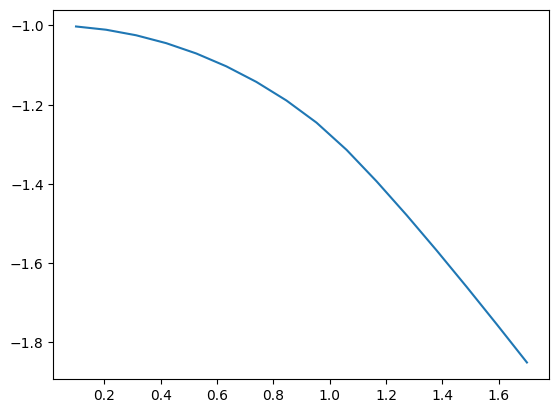

In [15]:
plt.plot(g_range, energies)